In [92]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pycaret.classification import *

Reading in the data and using one hot encoding

In [93]:
# Read the data into a pandas dataframe
df = pd.read_csv("diabetes_data.csv")
print(df.size)

# do some basic exploration
print("(Observations, Attributes (including target): ", df.shape)
print("DF contains null / nan values: ", df.isna().any().any())
for i in df.columns:
    print(f"Unique values for {i}: ", sorted(df[i].unique()))
    # plt.figure(figsize=(3, 1.5))
    # plt.title(f'{i}')
    # plt.hist(df[i])
print(df.describe())

# (for our report, we should describe how the categories were assessed (e.g. age buckets, what the 5 GenHlth categories correspond to etc.))

# As can be seen, many categories are actually binary, the rest is somewhat categorical although interpreting them continously might bear some benefit
# One hot encoding, dropfirst to remove the redundant column, since for sex they will have perfect negative corrolation (e.g. is_female and is_male)
# df = pd.get_dummies(df, columns=["Sex"], drop_first=True)
# One hot encoding for GeneralHealth since its a catagorical value from 1-5
# df = pd.get_dummies(df, columns=["GenHlth"])

1272456
(Observations, Attributes (including target):  (70692, 18)
DF contains null / nan values:  False
Unique values for Age:  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0]
Unique values for Sex:  [0.0, 1.0]
Unique values for HighChol:  [0.0, 1.0]
Unique values for CholCheck:  [0.0, 1.0]
Unique values for BMI:  [12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 89.0, 92.0, 95.0, 98.0]
Unique values for Smoker:  [0.0, 1.0]
Unique values for HeartDiseaseorAttack:  [0.0, 1.0]
Unique values for PhysActivity:  [0.0, 1.0]
Unique values for Fruits:  [0.0, 1.0]
Unique v

Checking for cyclical values and if we need to scale some features (maybe its better to leave some features unscaled for some models ???)

In [94]:

# Check if we have cyclical values | We dont :) often in form of months, days or any time series.

# Check scaling and what columns its need to do scaling (essentially if range is above 0<x<1 => we need to scale)
# our exploration above yields: Age, BMI, (GenHlth, now one-hot encoded,) MentHlth, PhysHlth

# Init of scaler
scaler = StandardScaler()

# Apply scaling for BMI, Mental health, Physical Health, and maybee age and GenHlth (depending on encoded or not) ??? 
# to benefit models like logistic regression, SVM or KNN
# We tested with this uncommented and it yielded a worse result for the best models
to_be_scaled = ["BMI", "MentHlth", "PhysHlth", "Age", "GenHlth"]
df[to_be_scaled] = scaler.fit_transform(df[to_be_scaled])

# print(df.describe())

# Splitting the data into data and target
data = df.drop("Diabetes", axis=1)
target = df["Diabetes"]

Now we split the data into triaining and test data

In [95]:
# Make a train and test split
# Train 80%
# Test 20%
# X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data, target, stratify=target, test_size=0.2, random_state=42)

Checking for correlation of features in our dataset

[]

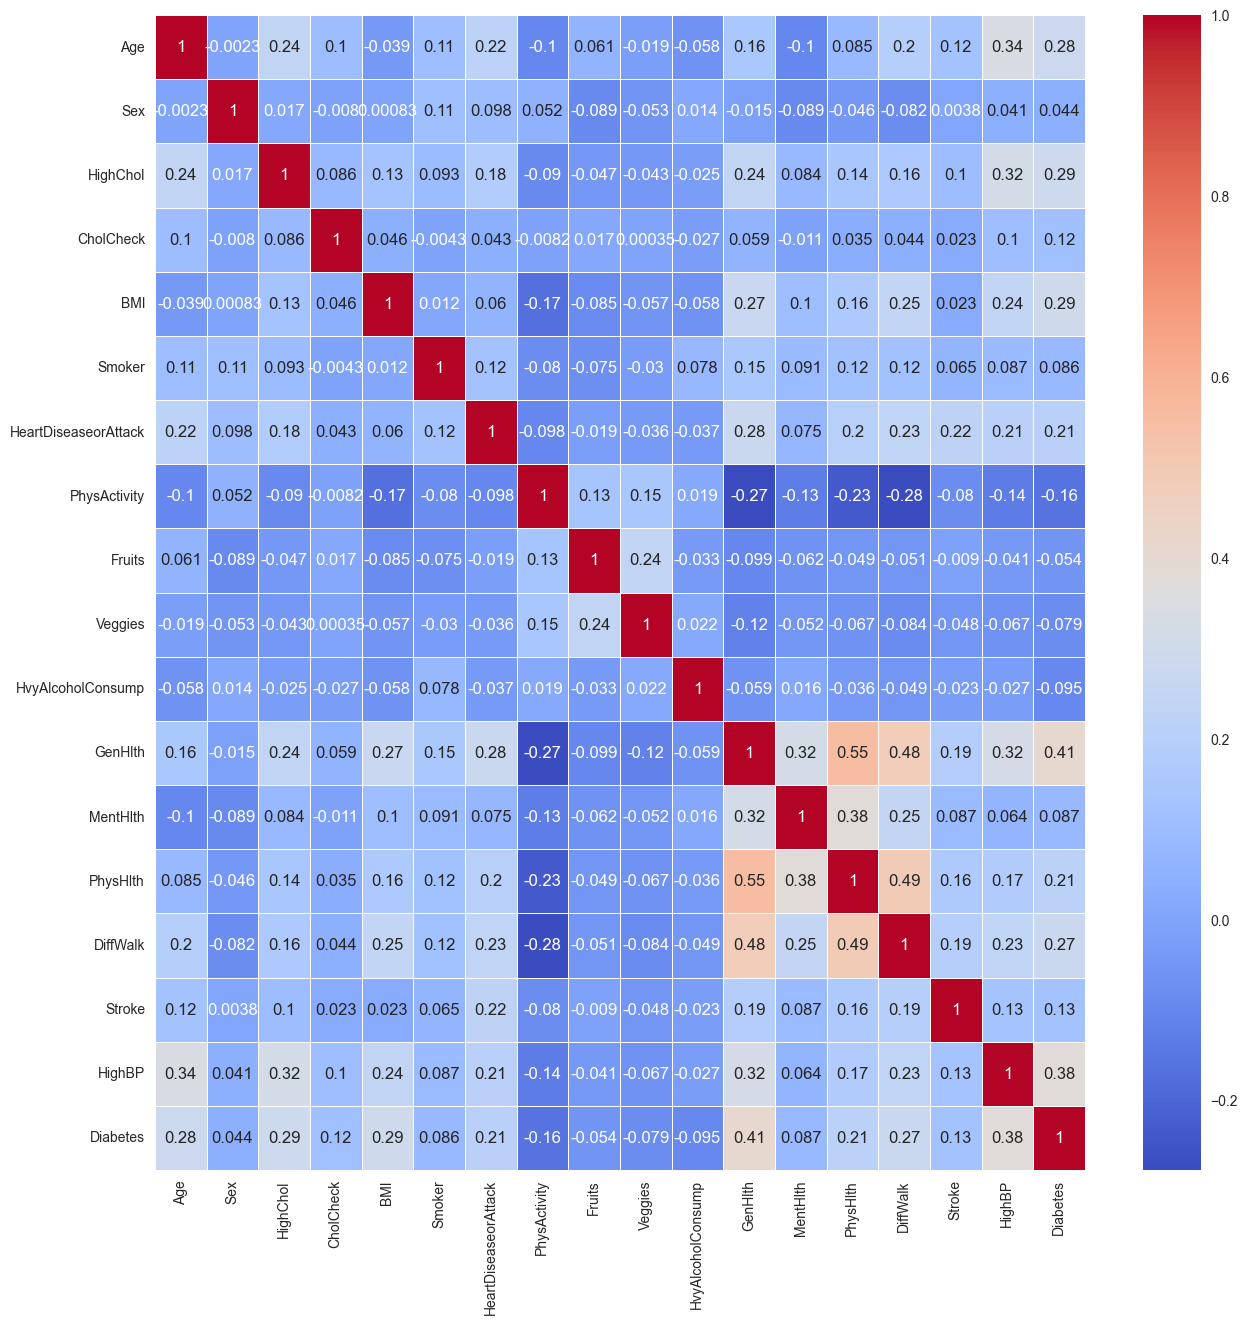

In [96]:
# Check features that are correlated
plt.figure(figsize=(15, 15))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.plot()
# there seems to be a slight linear correlation between GenHtlh and PhysHlth, we should address this / state what the threshold value would be and why

Using pycaret to choose top 5 models to train develope further with hyperparameters optimization 

In [97]:
train_data = X_train.copy()
train_data["Diabetes"] = y_train

# Pycaret for choosing the best models, pick top 5.
s = ClassificationExperiment()
s.setup(train_data, target = "Diabetes", session_id = 123)  #preprocessing probably also takes care of scaling e.g.
top_models = s.compare_models(n_select=5)

,Description,Value
0,Session id,123
1,Target,Diabetes
2,Target type,Binary
3,Original data shape,"(56553, 18)"
4,Transformed data shape,"(56553, 18)"
5,Transformed train set shape,"(39587, 18)"
6,Transformed test set shape,"(16966, 18)"
7,Numeric features,17
8,Preprocess,True
9,Imputation type,simple


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:33:59
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7500,0.8275,0.7912,0.7310,0.7599,0.4999,0.5017,0.4390
ada,Ada Boost Classifier,0.7479,0.8248,0.7722,0.7365,0.7538,0.4957,0.4964,0.1320
lda,Linear Discriminant Analysis,0.7459,0.8214,0.7756,0.7322,0.7532,0.4917,0.4927,0.0190
ridge,Ridge Classifier,0.7458,0.8214,0.7756,0.7321,0.7532,0.4917,0.4926,0.0140
lr,Logistic Regression,0.7454,0.8223,0.7664,0.7357,0.7507,0.4908,0.4914,0.2800
svm,SVM - Linear Kernel,0.7421,0.8200,0.7876,0.7238,0.7527,0.4842,0.4887,0.0250
qda,Quadratic Discriminant Analysis,0.7296,0.7832,0.7812,0.7082,0.7429,0.4592,0.4617,0.0200
rf,Random Forest Classifier,0.7276,0.7946,0.7623,0.7130,0.7367,0.4552,0.4564,0.3890
nb,Naive Bayes,0.7215,0.7854,0.7135,0.7252,0.7192,0.4429,0.4431,0.0130
knn,K Neighbors Classifier,0.7154,0.7719,0.7441,0.7038,0.7233,0.4308,0.4315,0.2010


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Hyper parameter tuning

In [ ]:
# built-in random-search by pycaret (took 2m 2.1s for me)
tuned_models = [s.tune_model(model) for model in top_models]

Lets try to use ensamble methods to get better results

In [ ]:
# Use blend models to try to get better accuracy 
clf = setup(data=train_data, target="Diabetes")

ensemble_model = blend_models(estimator_list=tuned_models, method="hard")
print(evaluate_model(ensemble_model))

In [ ]:

from sklearn.linear_model import LogisticRegression
# try to use stacking to see if thats any better
stacked_model_custom = s.stack_models(estimator_list=tuned_models, meta_model=LogisticRegression())


Lets try and see if feature selection does help ? 

In [ ]:
train_data = X_train.copy()
train_data["Diabetes"] = y_train

s = ClassificationExperiment()
# Setting feature selection to true
s.setup(train_data, target = "Diabetes", session_id = 123, preprocess=True, feature_selection=True) 
top_models = s.compare_models(n_select=5)

After trying stacking, blending and feature selection they all performed worse than the single model after hyperparameter tuning.

So lets just stick with the following

In [ ]:
# Making a copy of the training data
train_data = X_train.copy()
# Adding the target column to the df
train_data["Diabetes"] = y_train

# Pycaret for choosing the best models, pick top 5.
s = ClassificationExperiment()
s.setup(train_data, target = "Diabetes", session_id = 123, preprocess=True)  #preprocessing probably also takes care of scaling e.g.
# Selecting the top 5 models and display their scoring
top_models = s.compare_models(n_select=5)


In [ ]:
# Use blend models to try to get better accuracy 
clf = setup(data=train_data, target="Diabetes")

ensemble_model = blend_models(estimator_list=[top_models[0],top_models[2],top_models[4]], method="hard")
print(evaluate_model(ensemble_model))


from sklearn.linear_model import LogisticRegression
# try to use stacking to see if thats any better
stacked_model_custom = s.stack_models(estimator_list=[top_models[0],top_models[2],top_models[4]])
print(evaluate_model(stacked_model_custom))